# Homework 5



## Part 0
I choose the medical cost personal dataset. In particular, we run regression to predict personal health charges based on age and bmi.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# read the raw training data from csv file to a pandas dataframe
import pandas as pd
raw_training_data = pd.read_csv('/content/drive/MyDrive/STA365_DataSet/insurance.csv')

## Part I
We set up the PyMC confirgurations and conduct posterior inferences based on the model <br>
<br>
\begin{align*}\require{cancel}
\mathbf{y}_{n\times 1} \sim {} & \mathcal{MVN}(\mathbf{X}_{n\times p}\boldsymbol{\beta}_{p\times 1},\boldsymbol \Sigma_{n\times n} = \sigma^2I_{n\times n})\\
p(\mathbf{y}|\boldsymbol \beta, \sigma, \mathbf{X}) = {}& (2\pi )^{-n/2}{\frac{1}{\sigma^{\frac{n}{2}}}}\exp \left(-{\frac {1}{2\sigma^2}}(\mathbf {y} -\mathbf{X\boldsymbol\beta})^\top(\mathbf {y} - \mathbf{X\boldsymbol\beta})\right)\\\\
\boldsymbol\beta \sim {} & \mathcal{MVN}(\boldsymbol\beta_0, \boldsymbol\Sigma_\beta) \quad or\; \text{ we can have other proper support distribution of } \beta\\\\
\sigma \sim {} & \text{HalfNormal}(\mu_\sigma,\sigma_\sigma)\\\\
\end{align*}



In [30]:
import numpy as np
import pymc as pm
from scipy import stats

# Set seed
np.random.seed(123)

# Retreive the features matrix and respond vector
X = np.array(raw_training_data[['age', 'bmi']])
y = np.array(raw_training_data['charges'])
y = y.reshape(-1,1)

# Initialize Prior Hyperparameters
p = X.shape[1]
beta_0 = np.ones((p,1)) # Normal-Prior for Beta. Location parameter
cov_beta=np.eye(p)       # Normal-Prior for Beta. Scale parameter
mu_0 =1              # Half Normal Prior for sigma (scale parameter for the observe data)
sigma_0 = 1          # Half Normal Prior for sigma (scale parameter for the observe data)

# Initialize the student_T_mixture_model
MLR = pm.Model()
with MLR:
    betas = pm.MvNormal('betas', mu=beta_0, cov=cov_beta, shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=mu_0, sigma=sigma_0, lower=0)
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

In [32]:
# Conduct Hamiltonian Monte Carlo (HMC)
with MLR:
    idata = pm.sample()

### Sanity Check of Convergence


HMC Split-Rhats {'betas': array([[1.0005, 1.0017],
       [1.0009, 1.0017]]), 'sigma': 0.9995}


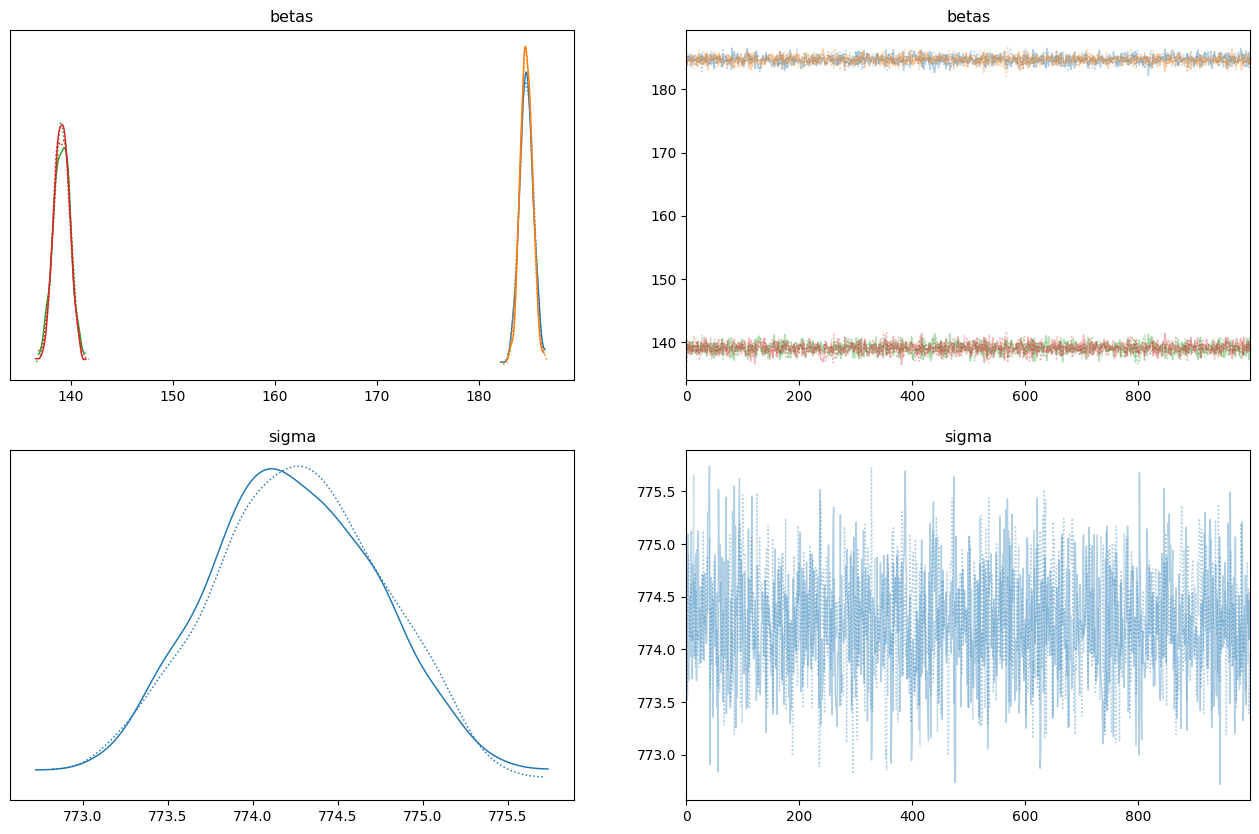

In [35]:
import arviz as az; import matplotlib.pyplot as plt;
fig,ax = plt.subplots(2,2, figsize=(16,10))
az.plot_trace(idata, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()})

### Credible Intervals - HDI
We generate 95% HDI for the degree of freedom parameter $\nu$

In [36]:
# Output the 95% Highest Density Interval
interval = az.hdi(idata, hdi_prob=0.95)
print(interval)

<xarray.Dataset>
Dimensions:      (betas_dim_0: 2, betas_dim_1: 2, hdi: 2)
Coordinates:
  * betas_dim_0  (betas_dim_0) int64 0 1
  * betas_dim_1  (betas_dim_1) int64 0 1
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    betas        (betas_dim_0, betas_dim_1, hdi) float64 183.4 185.9 ... 140.6
    sigma        (hdi) float64 773.2 775.2


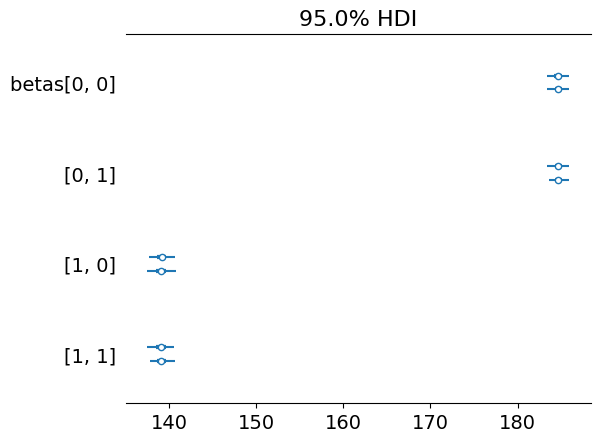

In [38]:
import arviz as az; import matplotlib.pyplot as plt; #fig,ax = plt.subplots(1,1, figsize=(14,6))
az.plot_forest(idata, var_names=["betas"], combined=False, hdi_prob=0.95);

## MCMC Chain Analysis
We conduct MCMC Chain analysis by ploting the MC chain, analysing its auto-correlation and effective sample size


## Effective Sample Size
We compute the effecitve sample size in this step. This is an alternative metric to assess the efficiency of our HMC approach.<br>
According to the computation, given a 4000 samples, the effective sample size is around 142. Which is significantly lower than the actual sample size. This observation is as expected since we have a very large autocorrelation of the MCMC chain.

In [40]:
import arviz as az; print("number of MCMC samples:", idata.posterior['betas'].values.flatten().shape[-1])
az.summary(idata, round_to=4)

number of MCMC samples: 8000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",184.6903,0.6559,183.4947,185.9562,0.0164,0.0116,1602.2047,1164.2278,1.0005
"betas[0, 1]",184.6742,0.6159,183.5971,185.8847,0.0154,0.0109,1583.6757,1260.5998,1.0017
"betas[1, 0]",139.0861,0.8043,137.5151,140.5488,0.0204,0.0144,1549.0476,1125.1941,1.0009
"betas[1, 1]",139.0736,0.7911,137.5673,140.5185,0.0211,0.0149,1404.3217,1019.2336,1.0017
sigma,774.2447,0.5176,773.2705,775.1765,0.0125,0.0088,1697.2582,1342.8233,0.9995


$$
\newcommand{\N}{\mathbb{N}}  % Natural numbers
\newcommand{\Z}{\mathbb{Z}}  % Integers
\newcommand{\R}{\mathbb{R}}  % Real numbers
\newcommand{\C}{\mathbb{C}}  % Complex numbers
\newcommand{\Q}{\mathbb{Q}}  % Rational numbers
\newcommand{\p}{\partial}  %  for partial derivatives
\newcommand{\f}{\frac} % fractions
\newcommand{\mb}{\mathbf}
\newcommand{\tr}{\mathrm{tr}}
\newcommand{\ra}{\Rightarrow}
\newcommand{\upa}{\uparrow}
\newcommand{\lra}{\Leftrightarrow}
\newcommand{\lan}{\langle}
\newcommand{\ran}{\rangle}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\inn}[1]{\lan#1\ran}
\newcommand{\floor}[1]{\lfloor#1\rfloor}
\newcommand{\ol}{\overline}
\newcommand{\cross}{\times}
\newcommand{\F}{\mathbf{F}}
\newcommand{\M}{\mathcal{M}}
\newcommand{\bhat}{\widehat}
\newcommand{\res}{\textrm{Res}}
\newcommand{\ds}{\displaystyle}
\newcommand{\range}{\textrm{range}}
\newcommand{\myhash}{\raisebox{\depth}{\#}}
$$

## Part II
Plug-in $\Sigma = \sigma^2 I$, we obtain
\begin{align}
  p(\pmb{y}|\pmb{\beta,\Sigma,X}) &\propto \exp \left[-\f{1}{2}(\pmb{\beta}-(X^T\Sigma^{-1}X)X^T\Sigma^{-1}y)^TX^T\Sigma^{-1}X(\pmb{\beta}-(X^T\Sigma^{-1}X)X^T\Sigma^{-1}y)\right]\\
  &\propto \exp\left[-\f{1}{2\sigma^2}(\pmb{\beta}-(X^TX)^{-1}X^Ty)^TX^TX(\pmb{\beta}-(X^TX)^{-1}X^Ty)\right]
\end{align}
So, with $$p(\pmb{\beta}) = MVN(E[\pmb \beta] = \pmb \beta_0, Cov[\pmb \beta]=\Sigma_{\beta})$$
we have
\begin{align*}
  p(\pmb \beta| \Sigma, X, y) = MVN(E[\pmb{\beta} | \Sigma, X,y], Cov[\pmb \beta|\Sigma, X,y])
\end{align*}
, where
\begin{align*}
  & Cov[\pmb \beta|\Sigma, X,y] = \sigma^2\left(X^TX + \Sigma_{\beta}^{-1}\right)^{-1} \\
  & E[\pmb \beta|\Sigma, X,y] = \sigma^2(X^TX + \Sigma_{\beta}^{-1})^{-1}\f{1}{\sigma^2}(X^Ty + \Sigma_{\beta}^{-1}\beta_0) = (X^TX + \Sigma_{\beta}^{-1})^{-1}(X^Ty + \Sigma_{\beta}^{-1}\beta_0)
\end{align*}
So, if we can make $\Sigma_{\beta}^{-1} = 0$, then we have
$$
  E[\beta|\Sigma,X,y] = (X^TX)^{-1}X^Ty
$$
as well as
$$
  E[X\beta|\Sigma,X,y] = X(X^TX)^{-1}X^Ty
$$
For $Cov[\beta|\Sigma,X,y]$, we have
$$
  Cov[\pmb \beta|\Sigma, X,y] = \sigma^2\left(X^TX + \Sigma_{\beta}^{-1}\right)^{-1}
$$


# Part III - Bayesian Multivariate Normal Model with


In [43]:
import numpy as np; from scipy import stats


# Retreive the features matrix and respond vector
X = np.array(raw_training_data[['age', 'bmi']])
y = np.array(raw_training_data['charges'])
y = y.reshape(-1,1)

# Set up parameters
p = X.shape[1] # Number of features
beta_0 = np.ones((p,1)) # Normal-Prior for Beta. Location parameter
cov_beta=np.eye(p)       # Normal-Prior for Beta. Scale parameter
mu_0 =1              # Half Normal Prior for sigma (scale parameter for the observe data)
sigma_0 = 1          # Half Normal Prior for sigma (scale parameter for the observe data)

#p=10; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
#n=1000; y=stats.multivariate_normal(mean=np.zeros(p), cov=a_cov).rvs(size=n)
# Replace this made up data with your data set from kaggle...

with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)

    # Transform the Cholesky factor to the covariance matrix
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    betas = pm.MvNormal('betas', mu=beta_0, cov=cov_beta, shape=(p,1))
    y = pm.MvNormal('y', mu=pm.math.dot(X, betas), chol=L, observed=y)
with MNV_LKJ:
    idata = pm.sample()